# <font color='red'>Step 1: Upload Data and Preprocess</font>

In [1]:
#package where fread function is to load csv file
library(data.table)
library(plyr)
library(dplyr)
library(tm)
library(tidytext)
library(stringr)
library(magrittr)
library(topicmodels)
library(igraph)
library(quanteda)
library(extrafont)
library(ggpubr)
font_import(prompt = FALSE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: NLP


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Package version: 4.1.0
Unicode version: 15.1
ICU version: 75.1

Parallel computing: disabled

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘package:tm’:

    stopwords


The following objects are 

In [2]:
df <- fread("/Users/heatherharper/Desktop/NMSU/RESEARCH_Ongoing/UK_Speech/hansard-speeches-UKCL-V2_finalfiltered.csv")

setwd("/Users/heatherharper/Desktop/NMSU/RESEARCH_Ongoing/UK_Speech/US_UK_NEW_Analysis2025/UK_Dover2000")

In [3]:
df <- df %>%
  mutate(date.yr.m = substr(date, 1, 6),
         month = substr(date, 5, 6))

#extra stop list; need to get rid of a couple that we don't need--was trying to figure out correct word form
new_stop <- c('also', 'hon', 'minister', 'debate', 'secretaries', 'secretar', 'governs', 'speaker', 'madam', 'congress',
              'secretary', 'bill', 'friend', 'committee', 'committees', 'will', 'government', 'governing', 'president', 
              'must', 'party', 'get', 'go', 'want', 'say', 'one', 'govern', 'people', 'peoples', 
              'come', 'can', 'us', 'know', 'mr', 'said', 'refer', 'however', 'make', '£', 'member', 'house', 'gentleman', 'gentlemen',
              'think', 'take', 'see', 'look', 'even', 'thing', 'let', 'go' )

#fix encoding 
df$speech <- iconv(df$speech, from = "UTF-8", to = "UTF-8", sub = "")

In [4]:
#preprocess and stem
df$text <-
  df$speech %>%
  tolower() %>%
  gsub("'s", '',.)%>%
  gsub('[0-9]+', '',.)%>%
  gsub("\\£", " ",.) %>%
  #gsub("\\£", " ",.)%>%
  str_replace_all(., pattern = "[:punct:]|(\\—)|([\\p{Pd}\\xAD\\u2212]+)", replacement = " ") %>%
  gsub('\\b\\w{1,2}\\b',' ',.) %>% #to get rid of words less than 3 letters long
  gsub("—", " ",.) %>%
  removeWords(., c(new_stop)) %>%
  removeWords(., stopwords("en")) %>%
  stemDocument(., language="english")

In [5]:
#make sure date variable is formatted as a date for subset code below
df$date <- as.Date(df$date, format= "%Y-%m-%d")

In [6]:
#recode parties to 3 
df <- df %>% mutate(party=recode(party, 
                                 'Ulster Unionist Party'='Other',
                                 'Liberal Democrat'='Other',
                                 'Speaker'='Other', 
                                 'Social Democratic & Labour Party'='Other',
                                 'Labour (Co-op)'='Other',
                                 'Scottish National Party'='Other',
                                 'Plaid Cymru'='Other',
                                 'Democratic Unionist Party'='Other',
                                 'Green Party'='Other',
                                 'Independent Conservative'='Other',
                                 'Independent Labour'='Other',
                                 'Independent SDP'='Other',
                                 'Independent Socialist'='Other',
                                 'Independent Unionist'='Other',
                                 'Liberal'='Other',
                                 'Respect'='Other',
                                 'Social Democratic Party'='Other',
                                 'The Independent Group for Change'='Other',
                                 'UK Independence Party'='Other',
                                 'Ulster Popular Unionist Party'='Other',
                                 'United Kingdom Unionist'='Other',
                                 'Alliance'='Other',
                                 'Change UK - The Independent Group'='Other',
                                 'Labour'='Labour',
                                 'Conservative'='Conservative',
                                 'Independent'='Other'))

In [7]:
table(df$party)


Conservative       Labour        Other 
       18188        13825         5640 

# <font color='orange'>Step 2: Select Event Period</font>

In [8]:
#2000 Dover
before_90 = "2000-03-20" 
before_1 = "2000-06-17"
event = "2000-06-18"
after_90 = "2000-09-16"
event_name = "2000 Chinese Dover"
event_name_pre = "Pre2000"
event_name_post = "Post2000"
event_short = "2000Event"


df_event <- subset(df, date>= before_90 & date <= after_90)

In [9]:
dim(df_event)

[1] 496  33

# <font color='green'>Step 3a: Run STM and get four different word weights </font>

In [10]:
library(ggraph)
library(stm)
library(ggplot2)
library(reshape2)
library(tidytext)
library(textstem)
library(textreg)
library(LDAvis)

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following objects are masked from ‘package:quanteda’:

    tokens, types


The following object is masked from ‘package:tm’:

    readTagged




In [11]:
#create covariate matrix
meta <- df_event %>% 
  select(date, party)

In [12]:
processed <- textProcessor(df_event$text)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


In [13]:
out <- prepDocuments(processed$documents, processed$vocab)

Removing 2229 of 5532 terms (2229 of 45736 tokens) due to frequency 
Your corpus now has 496 documents, 3303 terms and 43507 tokens.

In [14]:
#with covariates; not working currently 
Bill_STM <- stm(documents = out$documents, vocab = out$vocab,
              K = 20, prevalence =~ party,
              max.em.its = 75, data = df_event,
              init.type = "Spectral", verbose = FALSE)

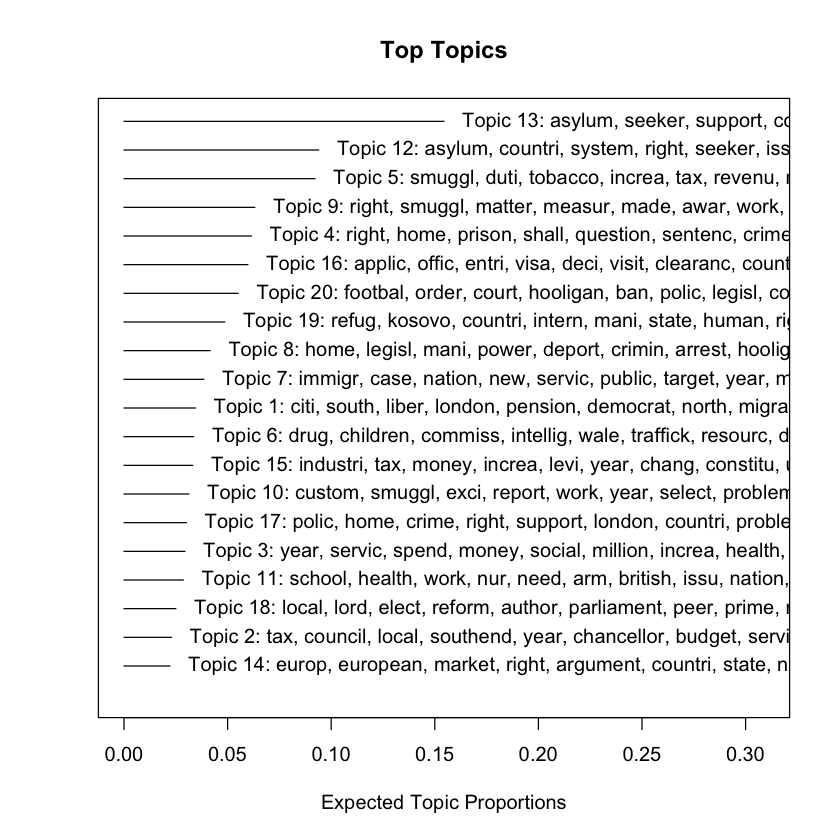

In [15]:
plot(Bill_STM, n=10)

#### labelTopics(Bill_STM) 

# <font color='green'>Step 4: Extract Gamma DF, Transform to Binary, divide into Pre and Post Period</font>

In [17]:
#create gamma matrix
dfg <- as.data.frame(Bill_STM$theta)

dfg[] <- t(apply(dfg, 1, function(x) replace(x, x == max(x, na.rm = TRUE), 1)))

In [18]:
#try to get gamma matrix for speeches
dfg_all <- rbind.fill( df_event, dfg)

#then convert rest of values using threshold
x <- 0.2
dfg[dfg>=x]=1
dfg[dfg<x]=0

In [19]:
dfg$author <- df_event$display_as
dfg$date <- df_event$date

#put author and date columns at the front
dfg <- dfg[, c(21:22, 1:20)]

In [20]:
#Event dfs
dfg_pre <- subset(dfg, date>= before_90 & date <= before_1) %>%
    select(-date)

dfg_post <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)

#Speeches in each
nrow(dfg_pre)
nrow(dfg_post)

[1] 323

[1] 173

In [21]:
dfg_pre = aggregate(dfg_pre,
                    by = list(dfg_pre$author),
                    FUN = max)

dfg_post = aggregate(dfg_post,
                     by = list(dfg_post$author),
                     FUN = max)

In [22]:
dim(dfg_pre)
dim(dfg_post)

[1] 126  22

[1] 85 22

# <font color='blue'> Step 5: PRE & POST Event Networks</font>

## <font color='DodgerBlue'> 5.1 Drop author names</font>

### PRE

In [23]:
### pre period- drop author names before running and rename topic names from V1 -> 1
rownames(dfg_pre) <- dfg_pre$Group.1

dfg_pre <- dfg_pre %>%
  select(-Group.1, -author)

colnames(dfg_pre) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

### POST

In [24]:
### pre period- drop author names before running and rename topic names from V1 -> 1
rownames(dfg_post) <- dfg_post$Group.1

dfg_post <- dfg_post %>%
  select(-Group.1, -author)

colnames(dfg_post) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

## <font color='DeepSkyBlue'> 5.2 Speaker-Concept Network</font>

### PRE **** CHANGE SIZES FOR EACH EVENT *******

In [107]:
dim(dfg_pre)
dim(dfg_post)

[1] 126  20

[1] 85 20

In [108]:
bn_full_pre <- graph_from_biadjacency_matrix(dfg_pre)


l7 <- layout_with_fr(bn_full_pre)
l7 <- norm_coords(l7, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes2 <- c(rep(5, 126), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

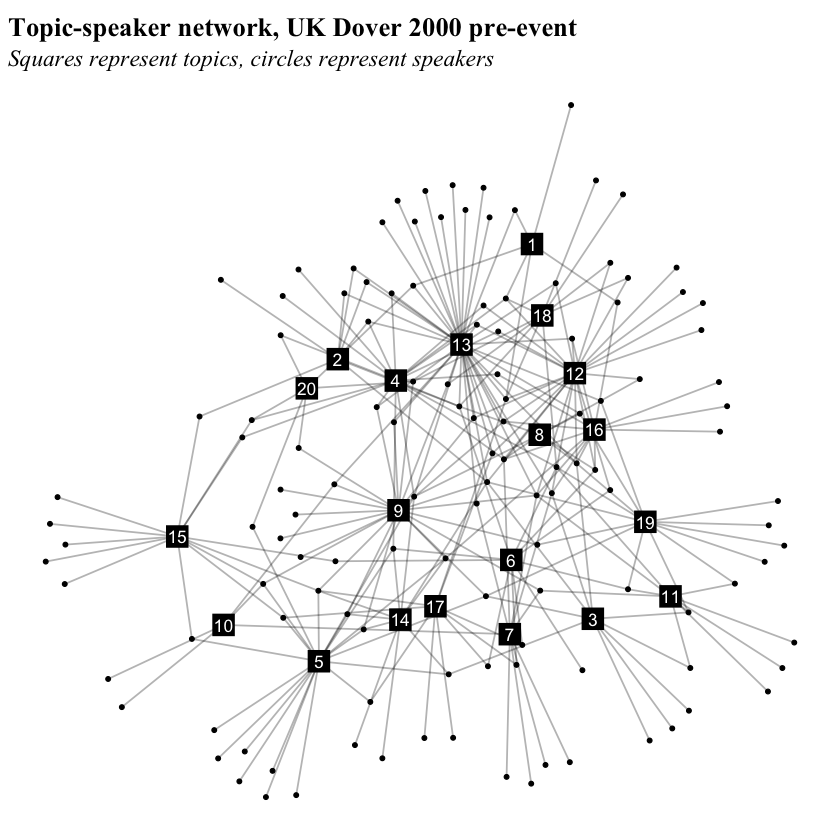

In [109]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre <- ggraph(bn_full_pre, layout = 'fr') +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Topic-speaker network, UK Dover 2000 pre-event",
    subtitle = "Squares represent topics, circles represent speakers"
  ) 

g_dov_pre

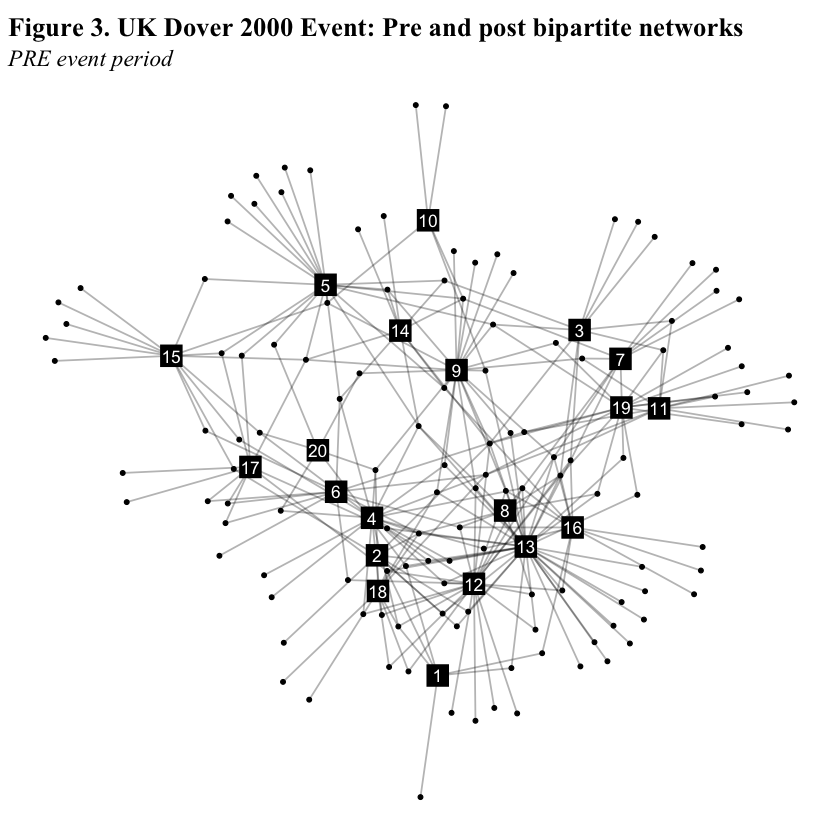

In [115]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre2 <- ggraph(bn_full_pre, layout = l7) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Figure 3. UK Dover 2000 Event: Pre and post bipartite networks",
    subtitle = "PRE event period"
  ) 

g_dov_pre2

### POST 

In [111]:
bn_full_post <- graph_from_biadjacency_matrix(dfg_post)


l8 <- layout_with_fr(bn_full_post)
l8 <- norm_coords(l8, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes3 <- c(rep(5, 85), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

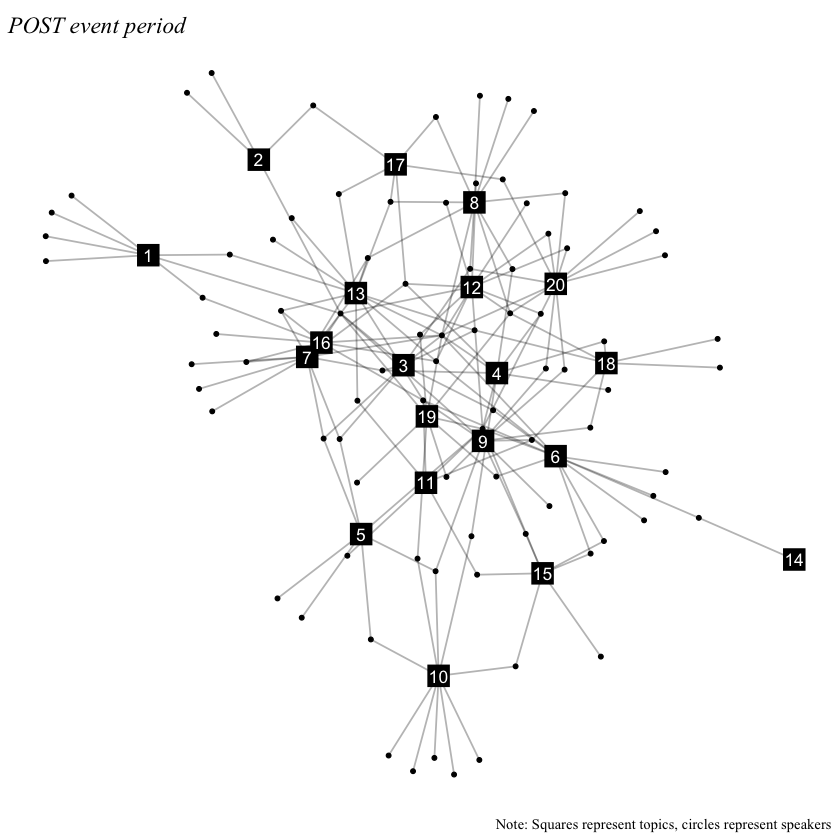

In [112]:
g_dov_post <- ggraph(bn_full_post, layout = l8) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_post)$type+1], size= sizes3)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    subtitle = "POST event period",
    caption = "Note: Squares represent topics, circles represent speakers"
  ) 

g_dov_post

In [116]:
combined_plot <- ggarrange(g_dov_pre2, g_dov_post,nrow=2, heights = c(2, 2), align="v")

## *****CHANGE NAME*******

In [117]:
ggsave("Dover2000combined_plot.jpeg", combined_plot, height = 10, width = 8)

## <font color='MediumPurple'> 6.3 Speaker-Speaker Network</font>

### PRE

In [33]:
### divide into actor-actor and concept-concept networks pre-period may-jul 15

# turn into bipartite network 
bn.pr_f_pre <- bipartite_projection(bn_full_pre)

# actor-actor
bn.mem_f_pre <- bn.pr_f_pre$proj1 
bn.mem_f_pre

# looking at edge weights  (1 = actors connected through 1 topic; 2 = connected through 2 topics...)
E(bn.mem_f_pre)$weight

# topic-topic 
bn.topics_f_pre <- bn.pr_f_pre$proj2
bn.topics_f_pre

l2 <- layout_with_fr(bn.mem_f_pre)
l2 <- norm_coords(l2, ymin=-0.8, ymax=0.7, xmin=-0.9, xmax=1)

IGRAPH 931b095 UNW- 126 1891 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 931b095 (vertex names):
 [1] Adam Ingram    --Ann Widdecombe  Adam Ingram    --Charles Clarke 
 [3] Adam Ingram    --James Clappison Adam Ingram    --John Bercow    
 [5] Adam Ingram    --Julie Morgan    Adam Ingram    --Oliver Heald   
 [7] Adam Ingram    --Paul Murphy     Adam Ingram    --Peter Hain     
 [9] Adam Ingram    --Phil Hope       Adam Ingram    --Tam Dalyell    
[11] Adam Ingram    --Ed Davey        Adam Ingram    --Eddie McGrady  
[13] Adam Ingram    --Fiona Jones     Adam Ingram    --Julian Brazier 
[15] Adam Ingram    --Nick Hawkins    Adam Ingram    --Oliver Letwin  
+ ... omitted several edges

[1] 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [38] 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1
  [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [186] 1 1 1 1 1 1 1 1 1 1 1 2 1 3 2 2 1 1 2 3 1 2 2 3 2 1 2 1 1 1 2 3 1 1 1 1 2
 [223] 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 [260] 1 1 1 1 1 2 4 4 1 1 1 1 3 2 2 1 2 4 1 2 2 1 1 1 1 3 1 1 1 2 1 1 3 1 1 1 1
 [297] 1 1 1 1 1 1 1 1 3 2 1 2 1 1 3 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [334] 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 3 3 1 2 2 1 3 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 [371] 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 [408] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [445] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 [482] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [519] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [556] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [593] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1
 [630] 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2 2 1 1 1 2 2 1 1 1 2 1 1 2 4 1 2 1 4 1 2 4
 [667] 2 3 3 2 1 2 3 1 1 3 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [704] 1 1 1 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1
 [741] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 2 1 1 2 1 2 1 2
 [778] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 2 1 1 1 1 2 1 2 2 2
 [815] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [852] 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 2
 [889] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 2 1 3 1 1 2 1 2 1 1 1 1 1
 [926] 2 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 [963] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 2 1 1 1 1 2 1 2 1 2 2 2 1 2 2 1 1 2
[1000] 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 3 1 1 1 1 2 1
[1037] 1 3 1 1 3 3 1 3 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1074] 1 1 1 1 1 1 2 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 1 1 1 1
[1111] 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1148] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1
[1185] 1 1 1 1 1 1 1 3 1 4 1 1 1 1 1 1 1 3 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
[1222] 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 1 2 1 1 1 1 1 1 2 3 2 1 3 2 1 2 2 2 1 1 1 1
[1259] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1296] 2 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
[1333] 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1370] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
[1407] 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
[1444] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 1 2
[1481] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 1 2 1 1 1
[1518] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1555] 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1592] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
[1629] 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
[1666] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2
[1703] 2 1 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1740] 1 1 1 1 1 1 1 1 1 1 1 1 2 3 2 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1777] 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[1814] 1 2 1 1 1 1 1 1 1 1 3 1 2 1

IGRAPH 7ccde39 UNW- 20 119 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 7ccde39 (vertex names):
 [1] 1--13 1--20 1--4  1--12 1--18 1--16 1--17 2--13 2--4  2--6  2--8  2--18
[13] 2--3  2--9  2--12 2--14 2--19 2--15 3--5  3--14 3--8  3--12 3--13 3--16
[25] 3--19 3--11 3--7  3--9  4--20 4--6  4--8  4--13 4--18 4--12 4--9  4--5 
[37] 4--14 4--7  4--16 4--15 4--11 4--19 5--9  5--14 5--16 5--17 5--15 5--8 
[49] 5--13 5--6  5--20 5--19 5--10 5--7  6--17 6--8  6--13 6--18 6--12 6--14
[61] 6--16 6--15 6--11 6--19 7--9  7--11 7--12 7--13 7--16 7--8  7--10 7--14
[73] 8--13 8--18 8--12 8--16 8--19 8--14 9--11 9--12 9--13 9--16 9--14 9--18
[85] 9--20 9--10 9--19 9--15 9--17
+ ... omitted several edges

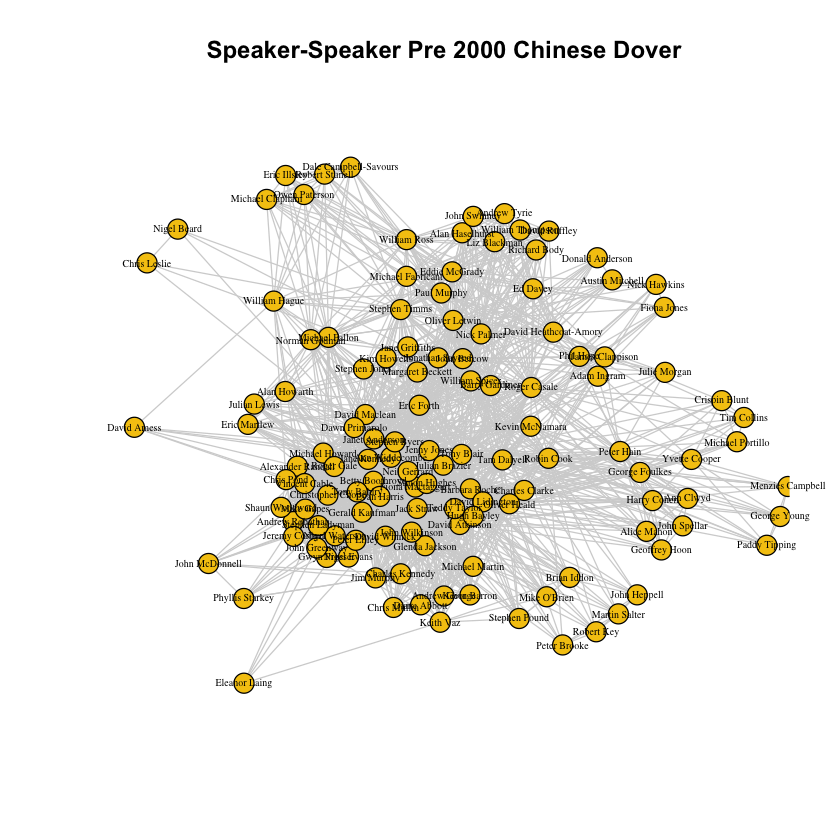

In [34]:
label2 = paste("Speaker-Speaker Pre", event_name, sep=" ")
set.seed(1)
plot(bn.mem_f_pre,vertex.color="#F5C710", main = label2,
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",edge.color = "light grey",
     vertex.size=7, vertex.label.cex=.5, layout= l2*1.2, rescale = FALSE)

### POST

In [35]:
### divide into actor-actor and concept-concept networks post-period 

# turn into bipartite network 
bn.pr_f_post <- bipartite_projection(bn_full_post)
bn.pr_f_post 

bn.mem_f_post <- bn.pr_f_post$proj1 
bn.mem_f_post

bn.topics_f_post <- bn.pr_f_post$proj2
bn.topics_f_post

$proj1
IGRAPH bd03e84 UNW- 85 665 -- 
+ attr: name (v/c), weight (e/n)
+ edges from bd03e84 (vertex names):
 [1] Alan Beith       --Ann Winterton    Alan Beith       --Caroline Spelman
 [3] Alan Beith       --Eddie McGrady    Alan Beith       --Eric Martlew    
 [5] Alan Beith       --Helen Jones      Alan Beith       --Jack Straw      
 [7] Alan Beith       --Jane Kennedy     Alan Beith       --John Battle     
 [9] Alan Beith       --Ross Cranston    Alan Beith       --Thomas King     
[11] Alan Beith       --Tony Blair       Alexander Randall--Hilary Benn     
[13] Alexander Randall--Jim Marshall     Alexander Randall--John Battle     
[15] Alexander Randall--Tom Brake        Alexander Randall--Tony Blair      
+ ... omitted several edges

$proj2
IGRAPH 039c206 UNW- 20 116 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 039c206 (vertex names):
 [1] 1--2  1--3  1--7  1--9  1--12 1--13 1--16 1--19 2--3  2--7  2--9  2--12
[13] 2--13 2--16 2--19 2--17 3--8  3--20 3--7  3--9  3--12 3--

IGRAPH bd03e84 UNW- 85 665 -- 
+ attr: name (v/c), weight (e/n)
+ edges from bd03e84 (vertex names):
 [1] Alan Beith       --Ann Winterton    Alan Beith       --Caroline Spelman
 [3] Alan Beith       --Eddie McGrady    Alan Beith       --Eric Martlew    
 [5] Alan Beith       --Helen Jones      Alan Beith       --Jack Straw      
 [7] Alan Beith       --Jane Kennedy     Alan Beith       --John Battle     
 [9] Alan Beith       --Ross Cranston    Alan Beith       --Thomas King     
[11] Alan Beith       --Tony Blair       Alexander Randall--Hilary Benn     
[13] Alexander Randall--Jim Marshall     Alexander Randall--John Battle     
[15] Alexander Randall--Tom Brake        Alexander Randall--Tony Blair      
+ ... omitted several edges

IGRAPH 039c206 UNW- 20 116 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 039c206 (vertex names):
 [1] 1--2  1--3  1--7  1--9  1--12 1--13 1--16 1--19 2--3  2--7  2--9  2--12
[13] 2--13 2--16 2--19 2--17 3--8  3--20 3--7  3--9  3--12 3--13 3--16 3--19
[25] 3--18 3--5  3--6  3--4  4--10 4--18 4--8  4--6  4--7  4--12 4--13 4--16
[37] 4--19 4--20 4--17 4--5  4--9  4--11 4--15 5--7  5--9  5--10 5--6  5--11
[49] 5--12 5--15 5--19 5--20 6--14 6--15 6--12 6--13 6--16 6--7  6--8  6--19
[61] 6--20 6--9  6--11 7--9  7--12 7--13 7--16 7--19 7--8  7--20 7--17 8--20
[73] 8--12 8--13 8--16 8--19 8--18 8--17 9--12 9--13 9--16 9--19 9--20 9--11
[85] 9--18 9--10 9--15
+ ... omitted several edges

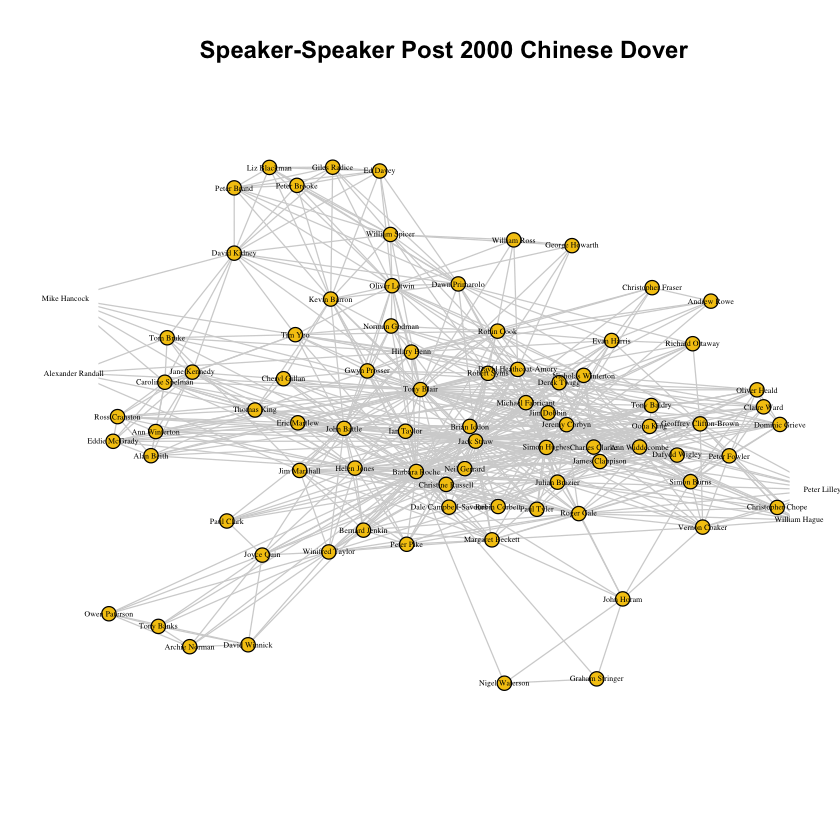

In [36]:
# members - members network post period 
label2= paste("Speaker-Speaker Post", event_name, sep=" ")

l11 <- layout_with_fr(bn.mem_f_post)
l11 <- norm_coords(l11, ymin=-0.8, ymax=0.7, xmin=-1.1, xmax=1.1)

set.seed(1)
plot(bn.mem_f_post,vertex.color="#F5C710", main = label2,
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",edge.color = "light grey",
     vertex.size=5, vertex.label.cex=.4, layout= l11*1.2, rescale = FALSE)

# <font color='Purple'> Step 6: Detect Communities with WalkTrap</font>

## <font color='DarkViolet'> 6A.1: Create Full Walktrap</font>

### PRE

In [98]:
#Create walktrap objects
cluster_pre <- cluster_walktrap(bn.mem_f_pre, steps=2) # 2 random steps 

V(bn.mem_f_pre)$community2 <-  membership(cluster_pre)

g_grouped = bn.mem_f_pre

for(i in unique(V(bn.mem_f_pre)$community2)){
  groupV = which(V(bn.mem_f_pre)$community2 == i)
  g_grouped = add_edges(g_grouped, combn(groupV, 2), attr=list(weight = 2))
}

l4 <- layout_nicely(g_grouped)

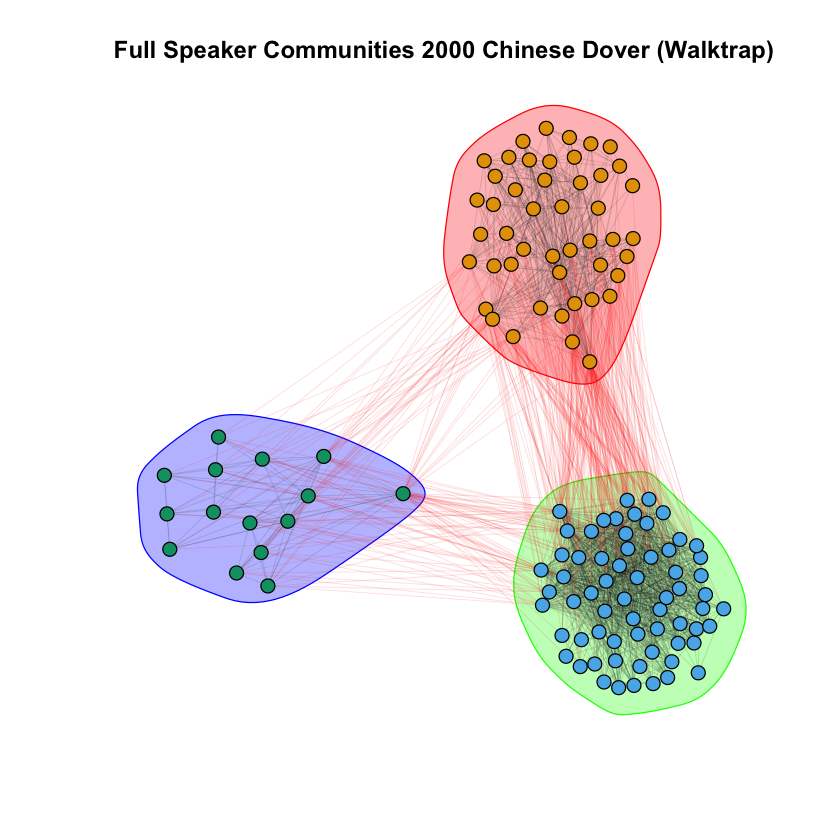

In [99]:
#Original Walktrap 
label4 = paste("Full Speaker Communities", event_name, "(Walktrap)", sep=" ")

set.seed(1)
#pv_pre <- plot(cluster_pre,bn.mem_f_pre,layout = l4*2, vertex.size = 5, edge.width = .1,
     #vertex.label.cex=.3, main = label4)

#don't show names
pv_pre <- plot(cluster_pre,bn.mem_f_pre,layout = l4*3, vertex.size = 5, edge.width = .1,
     vertex.label=NA, main = label4)

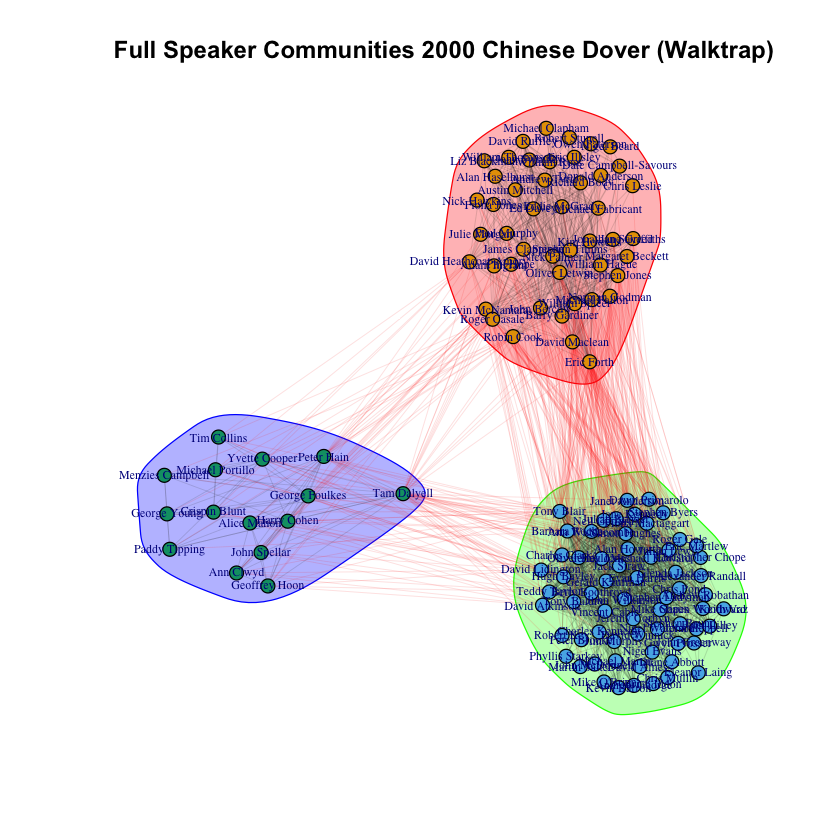

In [103]:
#With names
#Original Walktrap 
label4 = paste("Full Speaker Communities", event_name, "(Walktrap)", sep=" ")

set.seed(1)
pv_pre <- plot(cluster_pre,bn.mem_f_pre,layout = l4*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex=.6, main = label4)



### POST

In [100]:
#Create walktrap objects
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2) # 2 random steps 

V(bn.mem_f_post)$community2 <-  membership(cluster_post)

g_grouped_post = bn.mem_f_post

for(i in unique(V(bn.mem_f_post)$community2)){
  groupV = which(V(bn.mem_f_post)$community2 == i)
  g_grouped_post = add_edges(g_grouped_post, combn(groupV, 2), attr=list(weight = 2))
}

l11 <- layout_nicely(g_grouped_post)

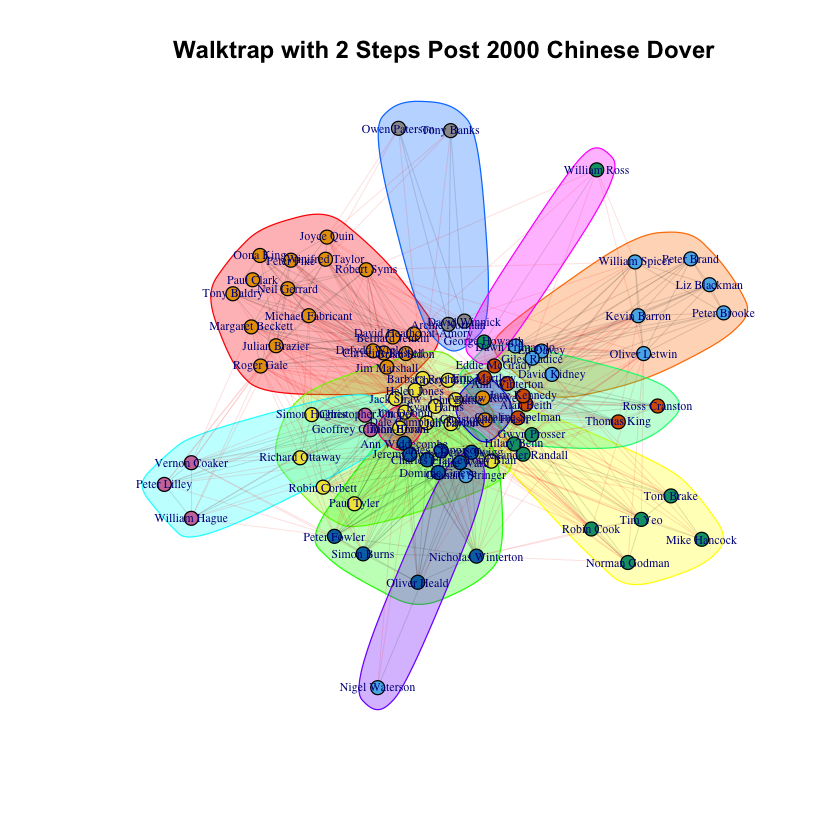

In [105]:
label11 = paste("Walktrap with 2 Steps Post", event_name, sep=" ")

set.seed(1)
#pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     #vertex.label.cex=.3, main = label11)

#Don't show names
pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex= 0.6, main = label11)

In [ ]:
label11 = paste("Walktrap with 2 Steps Post", event_name, sep=" ")

set.seed(1)
#pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     #vertex.label.cex=.3, main = label11)

#Don't show names
pv_post <- plot(cluster_post,bn.mem_f_post,layout = l11*2, vertex.size = 5, edge.width = .1,
     vertex.label= NA, main = label11)

# <font color='Magenta'> STEP 7: Create Subgraph with Core Clusters</font>

### PRE

In [45]:
#subgraph
membership.data.pre <- cbind(cluster_pre$names, cluster_pre$membership) %>%
  data.frame()

#filter out membership less than 5
big_group_pre <- membership.data.pre %>%
  group_by(X2) %>%
  filter(n() >= 5)

group_numbers_pre = membership.data.pre %>%
  group_by(X2) %>%
  filter(n() >= 5) %>%
  pull(X2) %>%
  unique()

In [46]:
big_names_pre <- big_group_pre$X1

nodes_party_sub_pre <- nodes_party_pre[sapply(lapply(nodes_party_pre$display_as, `%in%`, big_names_pre), any),]
nrow(nodes_party_sub_pre)

[1] 126

In [47]:
#adjust to your bn.member_f_pre object
Keep_pre = V(bn.m_pre)[name %in% big_group_pre$X1]

gD2_pre  = induced_subgraph(bn.m_pre, Keep_pre)

In [48]:
c_sub_pre = cluster_pre
c_sub_pre$names <- cluster_pre$names[Keep_pre]
c_sub_pre$membership <- cluster_pre$membership[cluster_pre$membership %in% group_numbers_pre]
c_sub_pre$vcount <- length(c_sub_pre$names)
c_sub_pre$modularity <- modularity(gD2_pre, c_sub_pre$membership, E(gD2_pre)$weight)

In [49]:
length(cluster_pre$names)
length(cluster_pre$membership)
length(cluster_pre$modularity)

length(c_sub_pre$names)
length(c_sub_pre$membership)
length(c_sub_pre$modularity)

[1] 126

[1] 126

[1] 126

[1] 126

[1] 126

[1] 1

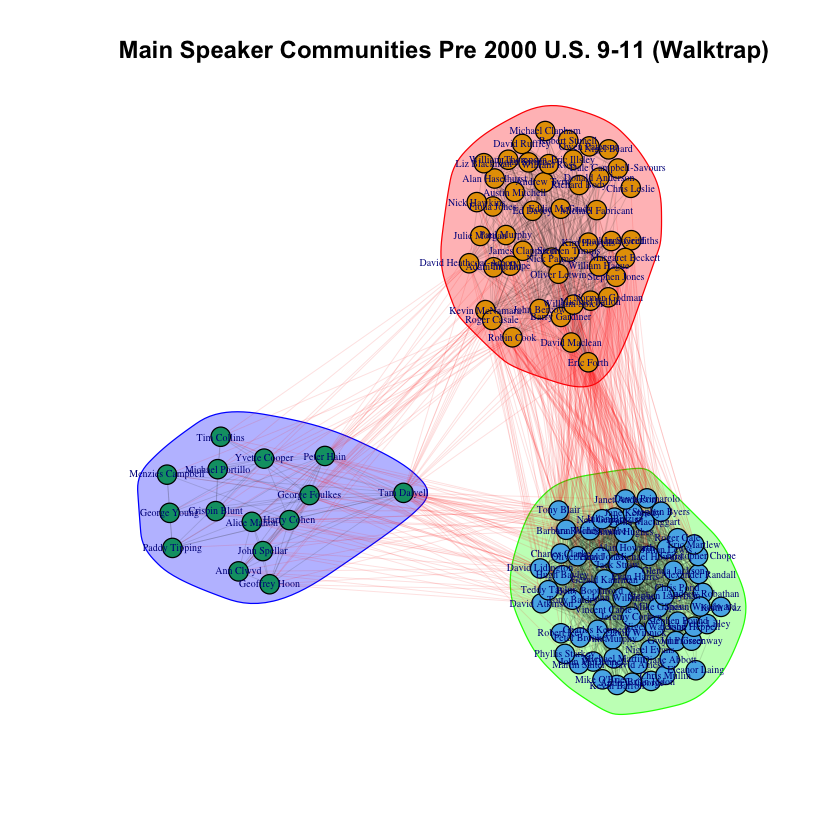

In [50]:
g_grouped_pre2 = gD2_pre

for(i in unique(V(gD2_pre)$community2)){
  groupV = which(V(gD2_pre)$community2 == i)
  g_grouped_pre2 = add_edges(g_grouped_pre2, combn(groupV, 2), attr=list(weight = 2))
}

l.group <- layout_with_fr(g_grouped_pre2)
l.group <- suppressWarnings(norm_coords(l.group, ymin=-1, ymax=1, xmin=-0.9, xmax=1))

l7 <- layout_nicely(g_grouped_pre2)

label7 = paste("Main Speaker Communities", event_name, "(Walktrap)", sep=" ")



set.seed(1)
plot(c_sub_pre, gD2_pre, layout = l.group*1.6, vertex.size = 7, edge.width = .1,
vertex.label.cex=.5, main = "Main Speaker Communities Pre 2000 U.S. 9-11 (Walktrap)")
##plot

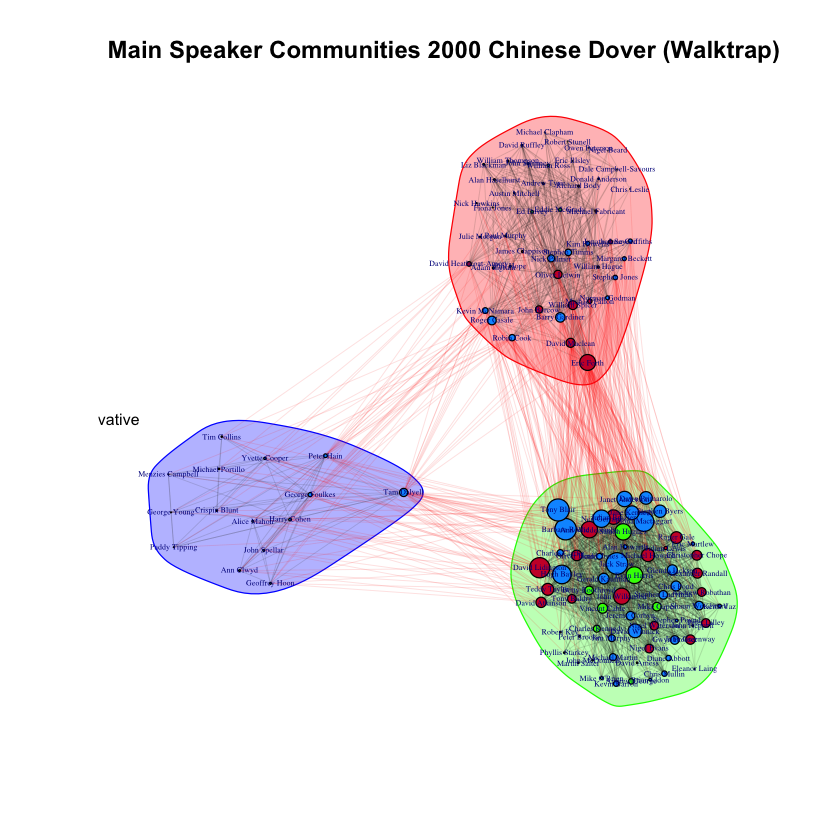

In [51]:
#old graphic code 
set.seed(1)
suppressWarnings(plot(c_sub_pre, gD2_pre, layout = l.group*1.6,
     col=colors[as.numeric(factor(nodes_party_sub_pre$party))],
     vertex.size = V(bn.m_pre)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label7))

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_sub_pre$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))

### POST

In [52]:
#subgraph
membership.data.post <- cbind(cluster_post$names, cluster_post$membership) %>%
  data.frame()

#filter out membership less than 5
big_group_post <- membership.data.post %>%
  group_by(X2) %>%
  filter(n() >= 5)
group_numbers_post <- membership.data.post %>%
  group_by(X2) %>%
  filter(n() >= 5) %>%
  pull(X2) %>%
 #as.numeric(.) %>%
  unique()


In [53]:
test4 <- membership.data.post %>%
    group_by(X2) %>%
    filter(n() >= 5) %>%
    pull(X2) %>%
    #as.numeric(.) 
    unique()

print(test4)

[1] "6" "3" "5" "4" "1" "7" "2"


In [54]:
big_names_post <- big_group_post$X1

nodes_party_sub_post <- nodes_party_post[sapply(lapply(nodes_party_post$display_as, `%in%`, big_names_post), any),]
nrow(nodes_party_sub_post)

[1] 74

In [55]:
#adjust to your bn.member_f_pre object
Keep_post = V(bn.m_post)[name %in% big_group_post$X1]

gD2_post  = induced_subgraph(bn.m_post, Keep_post)

In [56]:
c_sub_post = cluster_post
c_sub_post$names <- cluster_post$names[Keep_post]
c_sub_post$membership <- cluster_post$membership[cluster_post$membership %in% group_numbers_post]
c_sub_post$vcount <- length(c_sub_post$names)
c_sub_post$modularity <- modularity(gD2_post, c_sub_post$membership, E(gD2_post)$weight)

In [57]:
#determine largest group
table(cluster_post$membership) %>% sort()


12  9 10 11  8  7  3  6  2  5  4  1 
 1  2  2  2  4  5  8  8 10 11 14 18 

In [58]:
length(cluster_post$names)
length(cluster_post$membership)
length(cluster_post$modularity)

length(c_sub_post$names)
length(c_sub_post$membership)
length(c_sub_post$modularity)

[1] 85

[1] 85

[1] 85

[1] 74

[1] 74

[1] 1

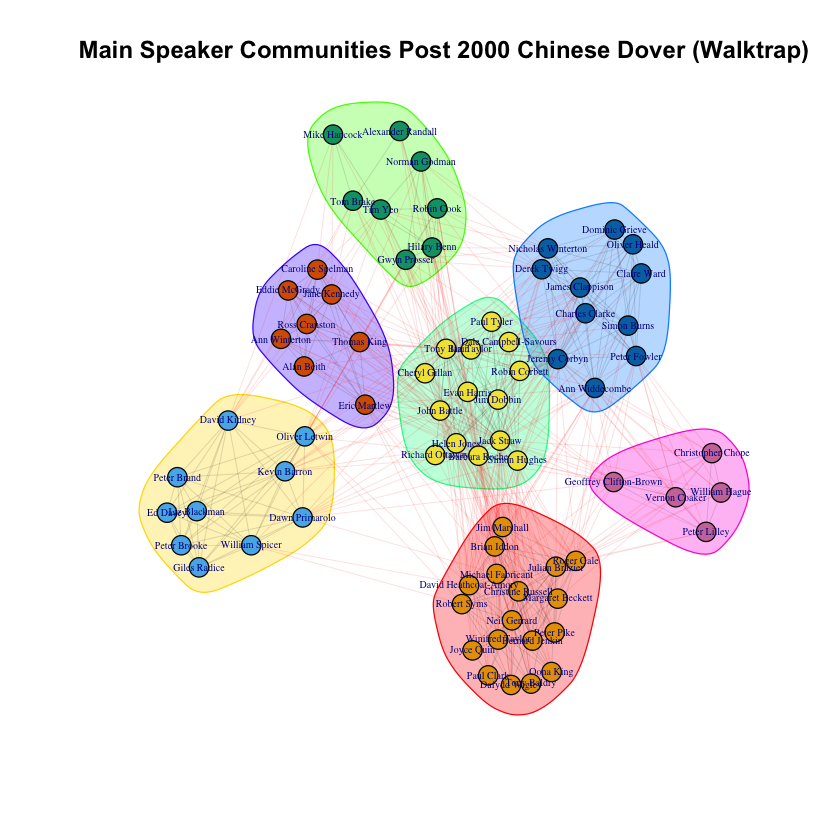

In [59]:
g_grouped_post2 = gD2_post

for(i in unique(V(gD2_post)$community2)){
  groupV = which(V(gD2_post)$community2 == i)
  g_grouped_post2 = add_edges(g_grouped_post2, combn(groupV, 2), attr=list(weight = 2))
}

l.group <- layout_with_fr(g_grouped_post2)
l.group <- suppressWarnings(norm_coords(l.group, ymin=-1, ymax=1, xmin=-0.9, xmax=1))

l14 <- layout_nicely(g_grouped_post2)

label14 = paste("Main Speaker Communities Post", event_name, "(Walktrap)", sep=" ")


set.seed(1)
plot(c_sub_post, gD2_post, layout = l.group*1.6, vertex.size = 7, edge.width = .1,
vertex.label.cex=.5, main = label14)
##plot

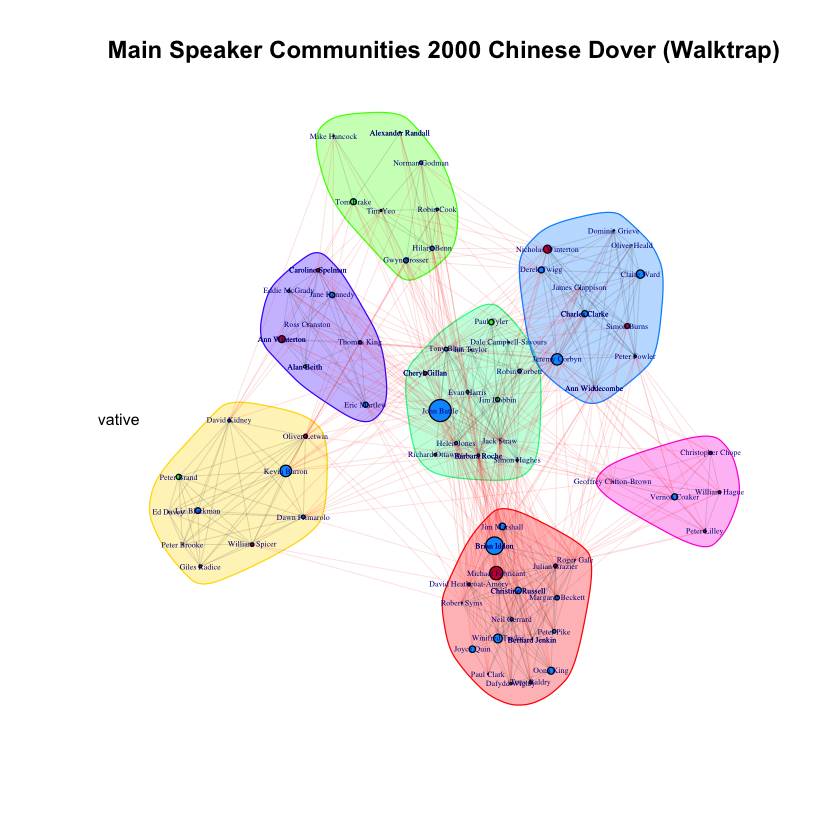

In [60]:
#old graphic code 
set.seed(1)
suppressWarnings(plot(c_sub_post, gD2_post, layout = l.group*1.6,
     col=colors[as.numeric(factor(nodes_party_sub_post$party))],
     vertex.size = V(bn.m_post)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label7))

legend(x = -1.5, y = 0,
       legend=levels(factor(nodes_party_sub_post$party)),
       col=colors, pch=c(19, 15), cex = 0.8, x.intersp= 0.1, y.intersp = 0.1,  
       bty='n', inset=c(-0.2,-0.1))

# <font color='Brown'> Step 8: Centrality Measures</font>

### PRE

In [61]:
### Centrality measures 
### DEGREE centrality actors: 

head(sort(degree(bn.mem_f_pre), decreasing=F)) # fewest connections: 

head(sort(degree(bn.mem_f_pre), decreasing=T)) # most connections:

Chris Leslie     Nigel Beard   Eleanor Laing     David Amess Austin Mitchell 
              4               4               5               7               9 
  Crispin Blunt 
              9

Tony Blair    Barbara Roche       Eric Forth  David Lidington 
              80               79               70               69 
      Jack Straw Fiona Mactaggart 
              68               67

In [62]:
### BETWEENNESS centrality actors: 
tail(sort(betweenness(bn.mem_f_pre,normalized = T))) # highest 

head(sort(betweenness(bn.mem_f_pre, normalized = T))) # lowest 

Tam Dalyell Oliver Letwin   Hugh Bayley    Tony Blair    Eric Forth 
   0.03410103    0.03550196    0.03640798    0.04080099    0.04495072 
Barbara Roche 
   0.05340551

Eleanor Laing          Chris Leslie           Nigel Beard 
         2.253537e-05          2.628834e-05          2.628834e-05 
Dale Campbell-Savours          Eric Illsley       Michael Clapham 
         3.865689e-05          3.865689e-05          3.865689e-05

### POST

In [63]:
### Centrality measures 
### DEGREE centrality actors: 

head(sort(degree(bn.mem_f_post), decreasing=F)) # fewest connections: 

head(sort(degree(bn.mem_f_post), decreasing=T)) # most connections:

Graham Stringer     Nigel Waterson  Alexander Randall        Andrew Rowe 
                 3                  3                  5                  6 
     Archie Norman Christopher Fraser 
                 6                  6

Jack Straw    Tony Blair Barbara Roche Jeremy Corbyn   John Battle 
           58            52            51            38            38 
  Helen Jones 
           33

In [64]:
### BETWEENNESS centrality actors: 
tail(sort(betweenness(bn.mem_f_post,normalized = T))) # highest 

head(sort(betweenness(bn.mem_f_post, normalized = T))) # lowest 

Oliver Letwin Jeremy Corbyn   John Battle    Tony Blair    Jack Straw 
   0.05077483    0.05078491    0.05913055    0.09250217    0.10055798 
Barbara Roche 
   0.14970189

Graham Stringer     Nigel Waterson        Andrew Rowe Christopher Fraser 
      0.000000e+00       0.000000e+00       2.206629e-05       2.206629e-05 
          Ed Davey       Giles Radice 
      5.160664e-05       5.160664e-05

# <font color='Grey'> Step 9: Extract Speaker and Community Info</font>

### PRE

In [65]:
### how to figure out who is in what community based on topics 
cluster_pre <- cluster_walktrap(bn.mem_f_pre, steps=2)
walk_comm <- as.data.frame(as.table(membership(cluster_pre)))
names(walk_comm) <- c("Speaker", "Community")

# create pre dataset again with speakers etc 

dfg_pre_2 <- subset(dfg, date>= before_90 & date <= before_1) %>%
    select(-date)


dfg_pre_2 = aggregate(dfg_pre_2,
                      by = list(dfg_pre_2$author),
                      FUN = max)

dfg_pre_2 <- dfg_pre_2 %>%
  select(-Group.1)

In [66]:
# Extract just names of speakers in each community 
fname = paste(event_name_pre, "STM_SpeakerbyCommunity.csv", sep="_")

pre_2steps_comm <- walk_comm
write.csv(pre_2steps_comm, file=fname)

In [67]:
# merge the dataset with communities now 
merge_dfg_pre <- merge(walk_comm, dfg_pre_2, walk_comm,  by.y = "author", by.x = "Speaker")

merge_dfg_pre[-1] <- lapply(merge_dfg_pre[-1], as.numeric)

# now create different metrics to see topic distribution per speaker/community
merge_dfg_pre <- merge_dfg_pre %>%
  mutate(topic_sum = rowSums(.[3:22])) %>%
  group_by(Community) %>%
  mutate(topic_mean = mean(topic_sum), topic_median = median(topic_sum), 
         topic_min = min(topic_sum),topic_max = max(topic_sum))

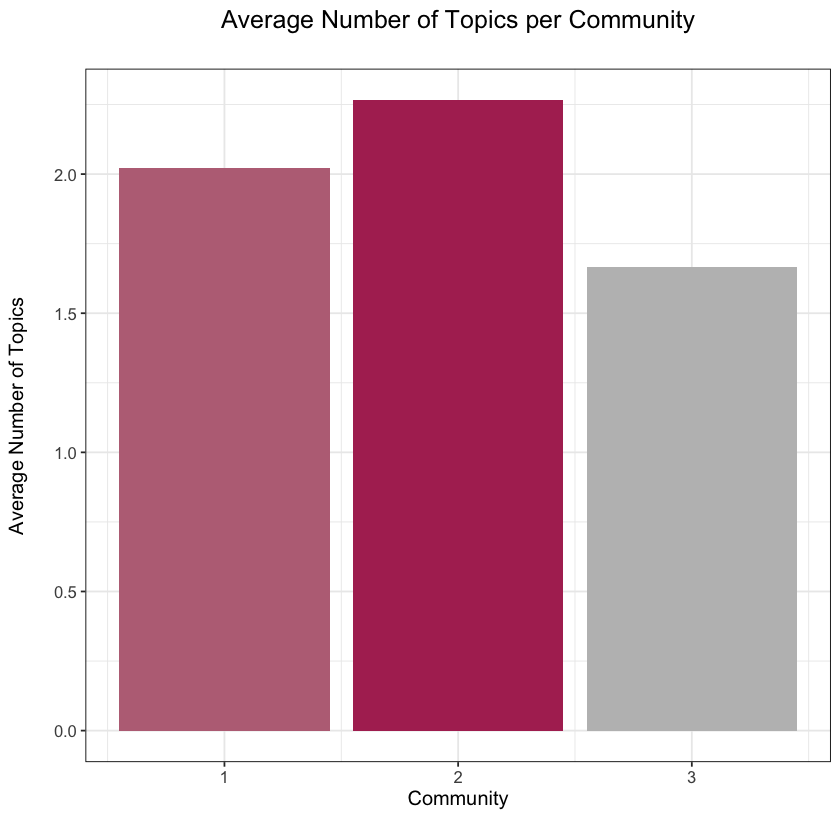

In [68]:
### Communities and Topics 

p1<- ggplot(merge_dfg_pre, aes(Community, topic_mean)) +
  geom_bar(aes(fill=topic_mean),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "maroon") +
  theme_bw() +
  ylab("Average Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Average Number of Topics per Community\n")

p1

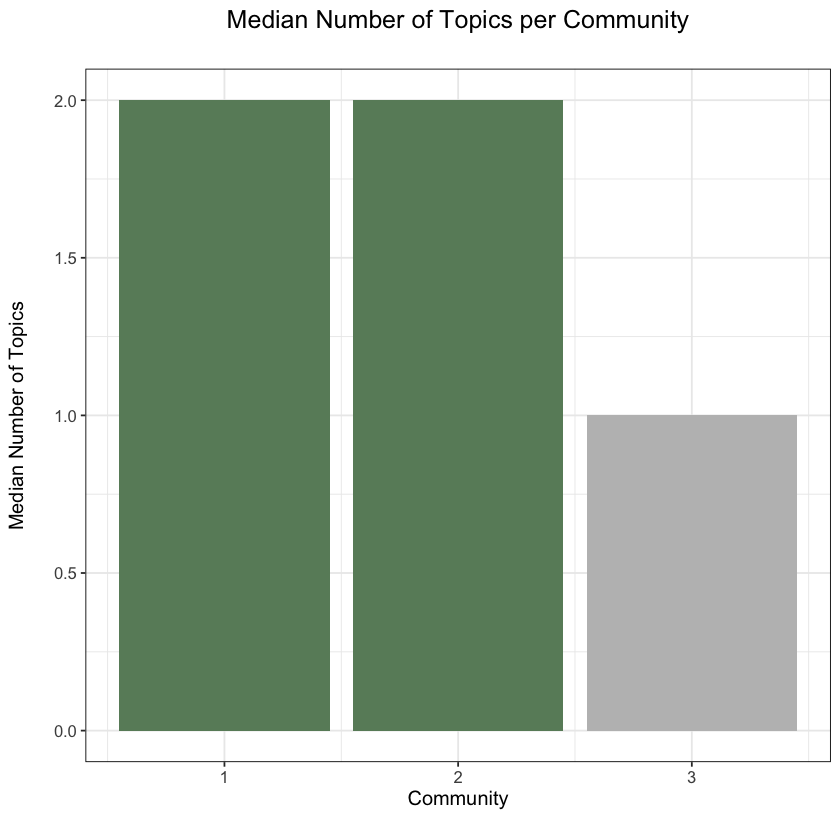

In [69]:
p2 <-  ggplot(merge_dfg_pre, aes(Community, topic_median)) +
  geom_bar(aes(fill=topic_median),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "darkseagreen4") +
  theme_bw() +
  ylab("Median Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Median Number of Topics per Community\n")

p2

In [70]:
#grid.arrange(p1, p2, nrow = 1) 
fname2 = paste(event_name_pre, "STM_NumSpeakersperCommunity.csv", sep="_")
# overall how often each topic is talked about 
colSums(merge_dfg_pre[ , c(3:22)], na.rm=TRUE)

# now how often each topic is talked about per community (ignore other columns, just focus on V1:V20)
aggregate(.~Community, merge_dfg_pre, sum)
walktrap_2steps <- aggregate(.~Community, merge_dfg_pre, sum)
write.csv(walktrap_2steps, file=fname2)

# count how many people in each community 
merge_dfg_pre %>% count(Community)

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
  6   8  10  19  20  11  10   7  22   5  10  24  37  10  13  13  10  10  14   6

Community Speaker V1 V2 V3 V4 V5 V6 V7 V8 ⋯ V16 V17 V18 V19 V20 topic_sum
1 1         3156    0  1  2   5 20 6  2  1  ⋯  1  8   1   2   4    95      
2 2         3850    6  7  3  13  0 3  8  6  ⋯ 12  2   8   4   2   145      
3 3          995    0  0  5   1  0 2  0  0  ⋯  0  0   1   8   0    25      
  topic_mean topic_median topic_min topic_max
1  95         94          47        235      
2 145        128          64        448      
3  25         15          15         75

Community n 
1 1         47
2 2         64
3 3         15

### POST

In [71]:
### how to figure out who is in what community based on topics 
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2)
walk_comm_post <- as.data.frame(as.table(membership(cluster_post)))
names(walk_comm_post) <- c("Speaker", "Community")

# create pre dataset again with speakers etc 

dfg_post_2 <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)

dfg_post_2 = aggregate(dfg_post_2,
                      by = list(dfg_post_2$author),
                      FUN = max)

dfg_post_2 <- dfg_post_2 %>%
  select(-Group.1)

In [72]:
# Extract just names of speakers in each community 
fname = paste(event_name_post, "STM_SpeakerbyCommunity.csv", sep="_")

post_2steps_comm <- walk_comm_post
write.csv(post_2steps_comm, file=fname)

In [73]:
# merge the dataset with communities now 
merge_dfg_post <- merge(walk_comm_post, dfg_post_2, walk_comm_post,  by.y = "author", by.x = "Speaker")

merge_dfg_post[-1] <- lapply(merge_dfg_post[-1], as.numeric)

# now create different metrics to see topic distribution per speaker/community
merge_dfg_post <- merge_dfg_post %>%
  mutate(topic_sum = rowSums(.[3:22])) %>%
  group_by(Community) %>%
  mutate(topic_mean = mean(topic_sum), topic_median = median(topic_sum), 
         topic_min = min(topic_sum),topic_max = max(topic_sum))

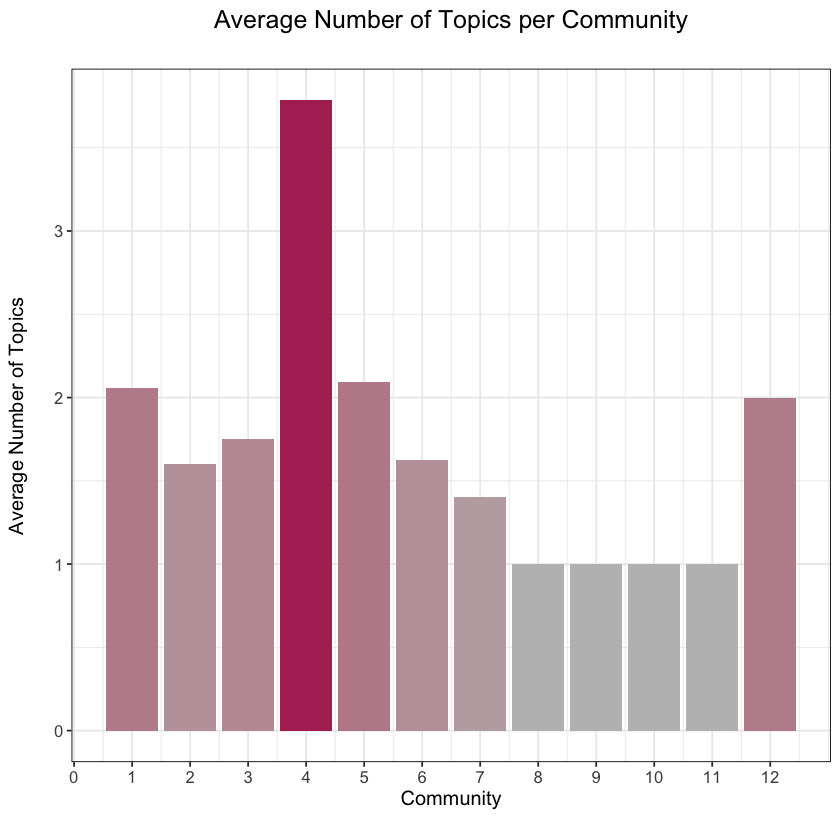

In [74]:
### Communities and Topics 

p3<- ggplot(merge_dfg_post, aes(Community, topic_mean)) +
  geom_bar(aes(fill=topic_mean),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "maroon") +
  theme_bw() +
  ylab("Average Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Average Number of Topics per Community\n")

p3

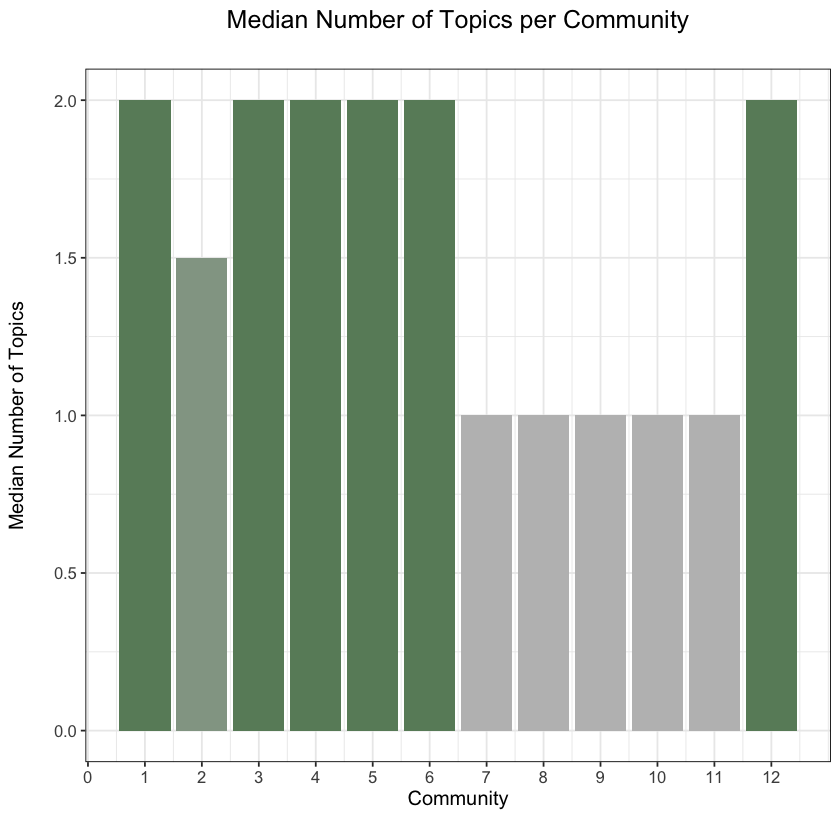

In [75]:
p4 <-  ggplot(merge_dfg_post, aes(Community, topic_median)) +
  geom_bar(aes(fill=topic_median),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "darkseagreen4") +
  theme_bw() +
  ylab("Median Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, linewidth=.5)) +
  ggtitle("Median Number of Topics per Community\n")

p4

In [76]:
#grid.arrange(p1, p2, nrow = 1) 
fname2 = paste(event_name_post, "STM_NumSpeakersperCommunity.csv", sep="_")
# overall how often each topic is talked about 
colSums(merge_dfg_post[ , c(3:22)], na.rm=TRUE)

# now how often each topic is talked about per community (ignore other columns, just focus on V1:V20)
aggregate(.~Community, merge_dfg_post, sum)
walktrap_2steps_post <- aggregate(.~Community, merge_dfg_post, sum)
write.csv(walktrap_2steps_post, file=fname2)

# count how many people in each community 
merge_dfg_post %>% count(Community)

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
  7   4   8   9   7  12  12  11  11  10   6  13  13   1   7   8   6   7  10  13

Community Speaker V1 V2 V3 V4 V5 V6 V7 V8 ⋯ V16 V17 V18 V19 V20 topic_sum
1   1        836     2  0  4  1  2  0  9  2  ⋯ 4   2   1   0    0  37       
2   2        459     0  0  0  1  2  0  0  0  ⋯ 0   0   0   1    0  16       
3   3        398     0  0  0  0  0  0  0  0  ⋯ 0   0   2   1    0  14       
4   4        608     1  1  2  6  1  4  3  1  ⋯ 4   1   1   6    2  53       
5   5        402     0  0  1  0  0  0  0  3  ⋯ 0   1   1   1   11  23       
6   6        255     0  0  1  0  0  8  0  0  ⋯ 0   0   0   1    0  13       
7   7        271     0  0  0  1  0  0  0  5  ⋯ 0   1   0   0    0   7       
8   8        165     4  0  0  0  0  0  0  0  ⋯ 0   0   0   0    0   4       
9   9         18     0  0  0  0  0  0  0  0  ⋯ 0   0   2   0    0   2       
10 10         86     0  2  0  0  0  0  0  0  ⋯ 0   0   0   0    0   2       
11 11        113     0  0  0  0  2  0  0  0  ⋯ 0   0   0   0    0   2       
12 12         44     0  1  0  0  0  0  0  0  ⋯ 0   1   0   0    0   2       
   topic_mean topic_median topic_min topic_max
1  37         36           18         54      
2  16         15           10         30      
3  14         16            8         24      
4  53         28           14        140      
5  23         22           11         55      
6  13         16            8         16      
7   7          5            5         10      
8   4          4            4          4      
9   2          2            2          2      
10  2          2            2          2      
11  2          2            2          2      
12  2          2            2          2

Community n 
1   1        18
2   2        10
3   3         8
4   4        14
5   5        11
6   6         8
7   7         5
8   8         4
9   9         2
10 10         2
11 11         2
12 12         1

# <font color='Red'> STEP 10:  Full Network Measures of Centrality, Transitivity, etc.</font>

In [77]:
pre_cent = centr_degree(bn.mem_f_pre)$centralization  ### somewhat high: 0.56 --> this speaks confirms that the network
pre_centrality = paste("Centrality of Pre", event_name, ":", pre_cent, sep=" ")
print(pre_centrality)
# is rather decentralized and hierarchical, with only a few nodes/actors being most important 
post_cent = centr_degree(bn.mem_f_post)$centralization
post_centrality = paste("Centrality of Post", event_name, ":", post_cent, sep=" ")
print(post_centrality)

cent_change = post_cent - pre_cent
centrality_change = paste("Change in Centrality", event_name, ":", cent_change, sep=" ")
print(centrality_change)

[1] "Centrality of Pre 2000 Chinese Dover : 0.399873015873016"
[1] "Centrality of Post 2000 Chinese Dover : 0.504201680672269"
[1] "Change in Centrality 2000 Chinese Dover : 0.104328664799253"


In [78]:
pre_edge = edge_density(bn.mem_f_pre) 
pre_edge_density = paste("Edge Density of Pre", event_name, ":", pre_edge, sep=" ")
print(pre_edge_density)

post_edge = edge_density(bn.mem_f_post)
post_edge_density = paste("Edge Density of Post", event_name, ":", post_edge, sep=" ")
print(post_edge_density)

edge_change = post_edge - pre_edge
density_change = paste("Change in Density", event_name, ":", edge_change, sep=" ")
print(density_change)

[1] "Edge Density of Pre 2000 Chinese Dover : 0.240126984126984"
[1] "Edge Density of Post 2000 Chinese Dover : 0.186274509803922"
[1] "Change in Density 2000 Chinese Dover : -0.0538524743230626"


In [79]:
pre_trans = transitivity(bn.mem_f_pre) 
pre_transitivity = paste("Transitivity of Pre", event_name, ":", pre_trans, sep=" ")
print(pre_transitivity)

post_trans = transitivity(bn.mem_f_post)
post_transitivity = paste("Transitivity of Post", event_name, ":", post_trans, sep=" ")
print(post_transitivity)

trans_change = post_trans - pre_trans
transitivity_change = paste("Change in Transitivity", event_name, ":", trans_change, sep=" ")
print(transitivity_change)

[1] "Transitivity of Pre 2000 Chinese Dover : 0.632129190063517"
[1] "Transitivity of Post 2000 Chinese Dover : 0.502525072907035"
[1] "Change in Transitivity 2000 Chinese Dover : -0.129604117156482"


In [80]:
# Pre-event average path length
pre_path = mean_distance(bn.mem_f_pre)
pre_path_length = paste("Average Path Length of Pre", event_name, ":", pre_path, sep=" ")
print(pre_path_length)

# Post-event average path length
post_path = mean_distance(bn.mem_f_post)
post_path_length = paste("Average Path Length of Post", event_name, ":", post_path, sep=" ")
print(post_path_length)

# Change in average path length
path_change = post_path - pre_path
path_length_change = paste("Change in Average Path Length", event_name, ":", path_change, sep=" ")
print(path_length_change)

[1] "Average Path Length of Pre 2000 Chinese Dover : 1.89003174603175"
[1] "Average Path Length of Post 2000 Chinese Dover : 2.04089635854342"
[1] "Change in Average Path Length 2000 Chinese Dover : 0.150864612511671"


In [81]:
#Get table with raw and changes:
# Calculate all network measures (your existing code creates these values)
# Pre values
pre_cent <- centr_degree(bn.mem_f_pre)$centralization
pre_edge <- edge_density(bn.mem_f_pre)
pre_trans <- transitivity(bn.mem_f_pre)
pre_path <- mean_distance(bn.mem_f_pre)

# Post values
post_cent <- centr_degree(bn.mem_f_post)$centralization
post_edge <- edge_density(bn.mem_f_post)
post_trans <- transitivity(bn.mem_f_post)
post_path <- mean_distance(bn.mem_f_post)

# Create summary table
network_summary <- data.frame(
  Measure = c("Degree Centralization", "Edge Density", "Transitivity", "Average Path Length"),
  Pre_Event = c(pre_cent, pre_edge, pre_trans, pre_path),
  Post_Event = c(post_cent, post_edge, post_trans, post_path),
  Raw_Change = c(post_cent - pre_cent, 
                 post_edge - pre_edge, 
                 post_trans - pre_trans, 
                 post_path - pre_path),
  Percent_Change = c(((post_cent - pre_cent) / pre_cent) * 100,
                     ((post_edge - pre_edge) / pre_edge) * 100,
                     ((post_trans - pre_trans) / pre_trans) * 100,
                     ((post_path - pre_path) / pre_path) * 100)
)

# Round for readability
network_summary$Pre_Event <- round(network_summary$Pre_Event, 4)
network_summary$Post_Event <- round(network_summary$Post_Event, 4)
network_summary$Raw_Change <- round(network_summary$Raw_Change, 4)
network_summary$Percent_Change <- round(network_summary$Percent_Change, 2)

# Print the table
print(network_summary)

# Optional: Create a nicer formatted table
library(knitr)
kable(network_summary, 
      caption = paste("Network Measure Changes for", event_name),
      col.names = c("Measure", "Pre-Event", "Post-Event", "Raw Change", "% Change"))

# Optional: Save to CSV
write.csv(network_summary, 
          file = paste0("network_changes_", event_name, "full",".csv"), 
          row.names = FALSE)

                Measure Pre_Event Post_Event Raw_Change Percent_Change
1 Degree Centralization    0.3999     0.5042     0.1043          26.09
2          Edge Density    0.2401     0.1863    -0.0539         -22.43
3          Transitivity    0.6321     0.5025    -0.1296         -20.50
4   Average Path Length    1.8900     2.0409     0.1509           7.98




Table: Network Measure Changes for 2000 Chinese Dover

|Measure               | Pre-Event| Post-Event| Raw Change| % Change|
|:---------------------|---------:|----------:|----------:|--------:|
|Degree Centralization |    0.3999|     0.5042|     0.1043|    26.09|
|Edge Density          |    0.2401|     0.1863|    -0.0539|   -22.43|
|Transitivity          |    0.6321|     0.5025|    -0.1296|   -20.50|
|Average Path Length   |    1.8900|     2.0409|     0.1509|     7.98|

## <font color='Red'> SUBGraph Measures of Centrality, Transitivity, etc.</font>

In [82]:
pre_cent = centr_degree(gD2_pre)$centralization  ### somewhat high: 0.56 --> this speaks confirms that the network
pre_centrality = paste("Centrality of Pre", event_name, ":", pre_cent, sep=" ")
print(pre_centrality)
# is rather decentralized and hierarchical, with only a few nodes/actors being most important 
post_cent = centr_degree(gD2_post)$centralization
post_centrality = paste("Centrality of Post", event_name, ":", post_cent, sep=" ")
print(post_centrality)

cent_change = post_cent - pre_cent
centrality_change = paste("Change in Centrality", event_name, ":", cent_change, sep=" ")
print(centrality_change)

[1] "Centrality of Pre 2000 Chinese Dover : 0.399873015873016"
[1] "Centrality of Post 2000 Chinese Dover : 0.567197334320622"
[1] "Change in Centrality 2000 Chinese Dover : 0.167324318447606"


In [83]:
pre_edge = edge_density(gD2_pre) 
pre_edge_density = paste("Edge Density of Pre", event_name, ":", pre_edge, sep=" ")
print(pre_edge_density)

post_edge = edge_density(gD2_post)
post_edge_density = paste("Edge Density of Post", event_name, ":", post_edge, sep=" ")
print(post_edge_density)

edge_change = post_edge - pre_edge
density_change = paste("Change in Density", event_name, ":", edge_change, sep=" ")
print(density_change)

[1] "Edge Density of Pre 2000 Chinese Dover : 0.240126984126984"
[1] "Edge Density of Post 2000 Chinese Dover : 0.227323213624583"
[1] "Change in Density 2000 Chinese Dover : -0.0128037705024007"


In [84]:
pre_trans = transitivity(gD2_pre) 
pre_transitivity = paste("Transitivity of Pre", event_name, ":", pre_trans, sep=" ")
print(pre_transitivity)

post_trans = transitivity(gD2_post)
post_transitivity = paste("Transitivity of Post", event_name, ":", post_trans, sep=" ")
print(post_transitivity)

trans_change = post_trans - pre_trans
transitivity_change = paste("Change in Transitivity", event_name, ":", trans_change, sep=" ")
print(transitivity_change)

[1] "Transitivity of Pre 2000 Chinese Dover : 0.632129190063517"
[1] "Transitivity of Post 2000 Chinese Dover : 0.522363847045191"
[1] "Change in Transitivity 2000 Chinese Dover : -0.109765343018325"


In [85]:
# Pre-event average path length
pre_path = mean_distance(gD2_pre)
pre_path_length = paste("Average Path Length of Pre", event_name, ":", pre_path, sep=" ")
print(pre_path_length)

# Post-event average path length
post_path = mean_distance(gD2_post)
post_path_length = paste("Average Path Length of Post", event_name, ":", post_path, sep=" ")
print(post_path_length)

# Change in average path length
path_change = post_path - pre_path
path_length_change = paste("Change in Average Path Length", event_name, ":", path_change, sep=" ")
print(path_length_change)

[1] "Average Path Length of Pre 2000 Chinese Dover : 1.89003174603175"
[1] "Average Path Length of Post 2000 Chinese Dover : 1.9333580155498"
[1] "Change in Average Path Length 2000 Chinese Dover : 0.0433262695180505"


In [86]:
# Calculate all network measures
# Pre values
pre_cent <- centr_degree(gD2_pre)$centralization
pre_edge <- edge_density(gD2_pre)
pre_trans <- transitivity(gD2_pre)
pre_path <- mean_distance(gD2_pre)

# Post values
post_cent <- centr_degree(gD2_post)$centralization
post_edge <- edge_density(gD2_post)
post_trans <- transitivity(gD2_post)
post_path <- mean_distance(gD2_post)

# Create summary table
network_summary <- data.frame(
  Measure = c("Degree Centralization", "Edge Density", "Transitivity", "Average Path Length"),
  Pre_Event = c(pre_cent, pre_edge, pre_trans, pre_path),
  Post_Event = c(post_cent, post_edge, post_trans, post_path),
  Raw_Change = c(post_cent - pre_cent, 
                 post_edge - pre_edge, 
                 post_trans - pre_trans, 
                 post_path - pre_path),
  Percent_Change = c(((post_cent - pre_cent) / pre_cent) * 100,
                     ((post_edge - pre_edge) / pre_edge) * 100,
                     ((post_trans - pre_trans) / pre_trans) * 100,
                     ((post_path - pre_path) / pre_path) * 100)
)

# Round for readability
network_summary$Pre_Event <- round(network_summary$Pre_Event, 4)
network_summary$Post_Event <- round(network_summary$Post_Event, 4)
network_summary$Raw_Change <- round(network_summary$Raw_Change, 4)
network_summary$Percent_Change <- round(network_summary$Percent_Change, 2)

# Print the table
print(network_summary)

# Optional: Create a nicer formatted table
library(knitr)
kable(network_summary, 
      caption = paste("Network Measure Changes for", event_name),
      col.names = c("Measure", "Pre-Event", "Post-Event", "Raw Change", "% Change"))

# Optional: Save to CSV
write.csv(network_summary, 
          file = paste0("network_changes_", event_name, "core", ".csv"), 
          row.names = FALSE)

                Measure Pre_Event Post_Event Raw_Change Percent_Change
1 Degree Centralization    0.3999     0.5672     0.1673          41.84
2          Edge Density    0.2401     0.2273    -0.0128          -5.33
3          Transitivity    0.6321     0.5224    -0.1098         -17.36
4   Average Path Length    1.8900     1.9334     0.0433           2.29




Table: Network Measure Changes for 2000 Chinese Dover

|Measure               | Pre-Event| Post-Event| Raw Change| % Change|
|:---------------------|---------:|----------:|----------:|--------:|
|Degree Centralization |    0.3999|     0.5672|     0.1673|    41.84|
|Edge Density          |    0.2401|     0.2273|    -0.0128|    -5.33|
|Transitivity          |    0.6321|     0.5224|    -0.1098|   -17.36|
|Average Path Length   |    1.8900|     1.9334|     0.0433|     2.29|